In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("dependencies")

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
import xgboost as xgboost
from itertools import cycle, islice

import pandas as pd
import numpy as np
import sklearn
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import classification_report
import random

## Load the dataset

We also show some of the rows.

In [16]:
feature_names = [
    "Age", "Workclass", "Education", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
df = pd.DataFrame(
    np.genfromtxt('adult.csv', delimiter=',', dtype=str, usecols=(0,1,3,6,7,8,9,10,11,12,13,14)),
    columns=feature_names
)

# Drop the first row as it is just the column names
df = df.drop(0)

df.head()

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
1,25,Private,11th,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
2,38,Private,HS-grad,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
3,28,Local-gov,Assoc-acdm,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
4,44,Private,Some-college,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,18,?,Some-college,?,Own-child,White,Female,0,0,30,United-States,<=50K


## Preprocessing

We begin with some light preprocessing of the data.

- We omit some of the columns because they are redundant. For example, `Education-Num` is the same as `Education`, the only difference is that one is in string and the other in numerals.
- We drop all rows that contain missing values.
- Define which rows are categorical and which are numerical.
- We discretize the `Age` and `Hours per week` features into bins (e.g. ages 15-25).

In [17]:
#Keep only needed columns
feature_names = [
    "Age", "Workclass", "Education", "Occupation", "Relationship", 
    "Race", "Sex", "Capital Gain","Capital Loss", "Hours per week", "Country", 
    "label"
]

df = pd.DataFrame(
  np.genfromtxt('adult.data', delimiter=', ', dtype=str, usecols=(0,1,3,6,7,8,9,10,11,12,13,14)),    
  columns=feature_names
)

#Drop missing values denoted as ?
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()


#Declare categorical columns
categorical_columns=[
   "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Country", "label"
]


for feature in feature_names:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        df[feature] = df[feature].astype("int")

#Make bins for age and hours per week
df['Age'] = pd.cut(df['Age'], bins=[16, 35 , 90],labels=['Young','Aged'])
df["Hours per week"] = pd.cut(
            x=df["Hours per week"],
            bins=[0.9, 25, 39, 40, 55, 100],
            labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"])

# replace "Husband" and "Wife" values with the unisex "Married"
df["Relationship"] = df["Relationship"].replace('Husband','Married')
df["Relationship"] = df["Relationship"].replace('Wife','Married')

df["label"] = df["label"].replace('>50K',1)
df["label"] = df["label"].replace('<=50K',0)

df.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
31610,Aged,Private,HS-grad,Handlers-cleaners,Married,White,Male,0,0,FullTime,United-States,0
8247,Aged,Local-gov,Some-college,Adm-clerical,Not-in-family,White,Female,0,0,FullTime,United-States,0
18910,Aged,Private,11th,Craft-repair,Married,White,Male,0,1485,OverTime,United-States,1
9683,Aged,State-gov,Bachelors,Adm-clerical,Married,White,Male,0,0,MidTime,United-States,1
8502,Young,Private,HS-grad,Handlers-cleaners,Own-child,White,Male,0,0,PartTime,United-States,0


## Generating a private dataset

In [18]:
def rand_resp(x, p=0.75, q=0.75):
    """
    Function to return randomized response
    """
    toss = random.random()
    # For Age variable
    if x in ['Young', 'Aged']:
    # if x in ['Young']:
        if toss <= p:
            return x  # Return true value with probability p
        else:
            return 'Aged' if x == 'Young' else 'Young'  # Return other category
            
    # For Sex variable
    elif x in ['Male', 'Female']:
    # elif x in ['Male']:
        if toss <= p:
            return x  # Return true value with probability p
        else:
            return 'Female' if x == 'Male' else 'Male'  # Return other category
            
    else:
        return x
    
# Create private dataset
random.seed(42)
pdf = df.copy()
pdf['Age'] = pdf['Age'].apply(lambda x: rand_resp(x, 0.90, 0.90))
pdf['Sex'] = pdf['Sex'].apply(lambda x: rand_resp(x, 0.90, 0.90))

pdf.head()



,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
0,Aged,State-gov,Bachelors,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,Aged,Self-emp-not-inc,Bachelors,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,Aged,Private,HS-grad,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,Aged,Private,11th,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,Young,Private,Bachelors,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## "Tabular" wrapper, train-test split and model training

For convenience, we use the `Tabular` class and relative helpers from the `omnixai` package.

The machine learning model we use are gradient boosted trees (links for reference: [1](https://en.wikipedia.org/wiki/Gradient_boosting), [2](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)). We chose this model class because they perform well on tabular data, but the specifics are not relevant. We are interested only in assessing the fairness of the model a posteriori.

Train-test splitting and model training are performed in the standard (`scikit-learn` - like) way.

In [24]:
def tabular_convert(df):
   # Convert the Tabular instances to transformed data 
   tabular_data = Tabular(
      df,
      categorical_columns=[
   "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
   ],
      target_column='label'
   )
   transformer = TabularTransform().fit(tabular_data)
   class_names = transformer.class_names
   x = transformer.transform(tabular_data)

   return tabular_data, transformer, class_names, x

def split_data(x):
   temp, test, temp_labels, test_labels = \
      sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80,random_state = 42)

   train, val, train_labels, val_labels = \
      sklearn.model_selection.train_test_split(temp, temp_labels, train_size=0.75,random_state = 42)

   test_labels = test_labels.astype(int)

   print('Training data shape: {}'.format(train.shape))
   print('Training data shape: {}'.format(val.shape))
   print('Test data shape:     {}'.format(test.shape))

   return train, val, train_labels, val_labels, test, test_labels

def train_model(train, val, train_labels, val_labels):
   model = lgb.LGBMClassifier(
      n_estimators=1000,
      learning_rate=0.05,
      num_leaves=32,
      max_depth=6,
      class_weight='balanced',
      min_child_samples=20,  # Add minimum number of samples required in a child
      verbose=-1,  # Suppress warnings
      random_state=42
   )
   # Train with early stopping
   model.fit(
      train, train_labels,
      eval_set=[(val, val_labels)],
      eval_metric='auc',
      callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=100)
      ]
   )
   return model

def tabular_revert(tabular_data, transformer, model, train, train_labels, test):
   predict_function = lambda z: model.predict_proba(transformer.transform(z))

   # Convert the transformed data back to Tabular instances
   train_data = transformer.invert(train)
   test_data = transformer.invert(test)

   display(tabular_data.target_column)
   display(train_labels[:2])
   return predict_function, train_data, test_data

Here are the model predictions.

In [75]:
# original data pipeline
tabular_data, transformer, x = tabular_convert(df)
train, val, train_labels, val_labels, test, test_labels = split_data(x)
model = train_model(train, val, train_labels, val_labels)
predict_function, train_data, test_data = tabular_revert(tabular_data, transformer, model, train, train_labels, test)

Training data shape: (18096, 99)
Training data shape: (6033, 99)
Test data shape:     (6033, 99)
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.914616	valid_0's binary_logloss: 0.3701
[200]	valid_0's auc: 0.920512	valid_0's binary_logloss: 0.352971
[300]	valid_0's auc: 0.921363	valid_0's binary_logloss: 0.349189
[400]	valid_0's auc: 0.92169	valid_0's binary_logloss: 0.347702
Early stopping, best iteration is:
[399]	valid_0's auc: 0.921702	valid_0's binary_logloss: 0.347721


'label'

array([1., 0.])

In [25]:
# private data pipeline
tabular_data, transformer,class_names, x = tabular_convert(pdf)
train, val, train_labels, val_labels, test, test_labels = split_data(x)
model = train_model(train, val, train_labels, val_labels)
predict_function, train_data, test_data = tabular_revert(tabular_data, transformer, model, train, train_labels, test)

Training data shape: (18096, 99)
Training data shape: (6033, 99)
Test data shape:     (6033, 99)
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.914616	valid_0's binary_logloss: 0.3701
[200]	valid_0's auc: 0.920512	valid_0's binary_logloss: 0.352971
[300]	valid_0's auc: 0.921363	valid_0's binary_logloss: 0.349189
[400]	valid_0's auc: 0.92169	valid_0's binary_logloss: 0.347702
Early stopping, best iteration is:
[399]	valid_0's auc: 0.921702	valid_0's binary_logloss: 0.347721


'label'

array([1., 0.])

Let's estimate the effectiveness of the model.

Test: accuracy=0.8284
Test: TP=1316, TN=3682, FP=821, FN=214


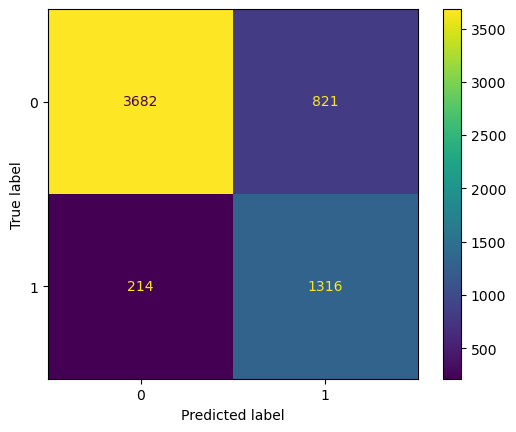

In [32]:
def evaluate(model, test_data, test, test_labels):
    test_df = test_data.to_pd()
    test_df["label"] = test_labels
    predictions = model.predict(test)
    test_df["prediction"] = predictions

    # test_df.sample(5)

    accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
    print(f'Test: {accuracy=:.4f}')

    cm = sklearn.metrics.confusion_matrix(test_labels, predictions)

    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, )
    disp.plot()

    return test_labels, predictions

    # generate classification report
    print(classification_report(test_labels, predictions))

test_labels, predictions = evaluate(model, test_data, test, test_labels)

# Global Explainability

We will see 2 global explainability methods:
- Accumulated Local Effects plots (ale): Visualize how features influence the average prediction of a model.
- Shapley Global values (shap_global): Calculate the contribution of each feature to the model.

In [27]:
explainers = TabularExplainer(
  explainers=["ale", "shap_global"],                 # The explainers to apply
  mode="classification",                             # The task type
  data=train_data,                                   # The data for initializing the explainers
  model=model,                                       # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
)

global_explanations = explainers.explain_global()

100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


In [28]:
print("ALE results:")
global_explanations["ale"].ipython_plot(class_names=class_names)

ALE results:


In [ ]:
print("SHAP results:")
global_explanations["shap_global"].ipython_plot(class_names=class_names)

SHAP results:


# Local Explainability on wrong but confident predictions

#### Find wrong but confident predictions

In [33]:
# Find instances where the predicted label is different from the actual label
miss_indices = np.where(predictions != test_labels)[0]

# Create the prediction probabilities
proba = model.predict_proba(test)

# Find instances where the model is very confident but wrong
miss_but_confident = []

for idx in miss_indices:
    if max(proba[idx]) > 0.95:
        miss_but_confident.append(idx)
    
print(f"There are {len(miss_but_confident)} instances where the model is very confident but wrong.")

instance_id = miss_but_confident[0]

print(f"For example, instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")

There are 22 instances where the model is very confident but wrong.
For example, instance 142 has label 1 and prediction 0.0, with probs [0.98778347 0.01221653]


#### Explain these instance using LIME and MACE.

In [34]:
explainers = TabularExplainer(
  explainers=['lime', 'mace'],                       # The explainers to apply
  mode="classification",                             # The task type
  data=train_data,                                   # The data for initializing the explainers
  model=model,                                       # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
  params={
        "mace": {"ignored_features": ["Sex", "Race"]}# params which cannot change when creating counterfactuals
    }
)


test_instances = test_data[instance_id:instance_id+1]
local_explanations = explainers.explain(X=test_instances)

In [35]:
print("LIME explanation")

print(f"Instance {instance_id} has label {test_labels[instance_id]} but prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
local_explanations["lime"].ipython_plot(index=0, class_names=class_names)

LIME explanation
Instance 142 has label 1 but prediction 0.0, with probs [0.98778347 0.01221653]


In [37]:
print("MACE explanation")

# query_df = pd.DataFrame(columns=local_explanations['mace'].get_explanations()[0]['query'].columns)
query_df = local_explanations['mace'].get_explanations()[0]['query'].reset_index(drop=True)
query_df.index = [f"{instance_id}"] * len(query_df)


counter_df = local_explanations['mace'].get_explanations()[0]['counterfactual'].reset_index(drop=True)
counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]

combined_df = pd.concat([query_df, counter_df])

# Highlighting function
def highlight_changes(row):
    instance_row = combined_df.iloc[0]  # Reference row for the instance
    return ["color: red" if row[col] != instance_row[col] else "" for col in combined_df.columns]

styled_df = combined_df.style.apply(highlight_changes, axis=1)


display(styled_df)


MACE explanation


,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
142,Young,State-gov,HS-grad,Transport-moving,Not-in-family,Amer-Indian-Eskimo,Male,0.000000,0.000000,MidTime,United-States,0
CF[0] for 142,Young,State-gov,Bachelors,Transport-moving,Married,Amer-Indian-Eskimo,Male,0.000000,0.000000,OverTime,United-States,1
CF[1] for 142,Young,Self-emp-inc,Bachelors,Prof-specialty,Married,Amer-Indian-Eskimo,Male,0.000000,0.000000,MidTime,United-States,1
CF[2] for 142,Aged,State-gov,Bachelors,Transport-moving,Married,Amer-Indian-Eskimo,Male,0.000000,0.000000,FullTime,United-States,1
CF[3] for 142,Young,Self-emp-not-inc,HS-grad,Machine-op-inspct,Not-in-family,Amer-Indian-Eskimo,Male,4787.000000,1466.250000,FullTime,United-States,1
